# 머신러닝 과제 발표자료

# 주제: Shelter Animal Outcomes

In [1]:
'''Import all the necessary packages'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
import xgboost

from patsy import dmatrix
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import requests
from bs4 import BeautifulSoup

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\cck3\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 인자설명 및 과제 목표

종속변수 (y): OutcomeType -> Returned to owner, Adoption, Transfer, Euthanasia, Died

독립변수 (X): AnimalID, Name, DateTime, OutcomeSubType, AnimalType, SexuponOutcome, AgeuponOutcome, Breed, Color

(추가 설명 첨부 필요)

주어진 종속변수를 사용하여 Shelter 애완동물의 Outcome을 예측하는 프로젝트. 예측 Outcome으로는 Returned to Owner, Transfer, Adoption, Euthanasia, Death가 있다.

## EDA & Feature Engineering

In [2]:
data_train = pd.read_csv('train.csv')

'''Keep a copy of the original data for comparison'''
data_original = data_train.copy()

### 1) NaN값 파악

In [3]:
def graph_na(data_train):
    plt.figure()
    missing_data_count = data_train.isnull().sum()
    missing_data_count.sort_values(ascending = False, inplace = True)
    missing_data_count_filtered = missing_data_count[missing_data_count > 0]
    missing_data_count_filtered.plot(kind = 'bar', title = 'missing data count')
    plt.show()

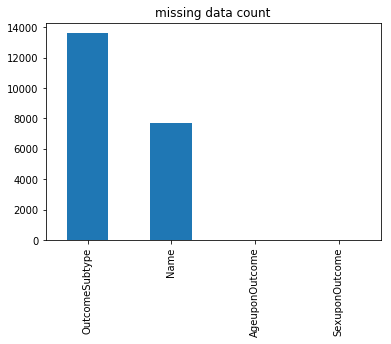

In [4]:
graph_na(data_train)

In [5]:
#Data 확인
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


#### Name -> Shelter에 맞겨졌을 당시 이름 유/무 사항 (이름 유/무에 따른 결과값 분석 필요)
#### OutcomeSubtype -> OutcomeType과 직관적으로 연결된 인자 (데이터 분석에는 적용 x)
#### AgeUponOutcome과 SexuponOutcome NaN값은 갯수가 많지 않기 때문에 제거

### 1.2) Name -> 이름이 있을경우 'Name'으로 없을경우 No Name'으로 변환

In [6]:
def no_name_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    if type(x) == float:
        return 'No Name'
    else:
        return 'Name'

In [7]:
data_train['Name'] = data_train['Name'].transform(no_name_label)

### 1.3) OutcomeSubtype -> 없을 경우 'Unknown'으로 대체

In [8]:
data_train['OutcomeSubtype'] = data_train['OutcomeSubtype'].fillna('Unknown')

In [9]:
#Data 확인
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Name,2015-03-09 13:33:00,Adoption,Unknown,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


### 2) 날짜 데이터 분류 -> 날짜 데이터에서 년, 월, 일, 시간 자료 추출 및 계절 변수 형성

In [10]:
def datetime_str_converter(data_train):
    '''This method converts the datetime input into year and month in
    string format. The below method is identical except it returns numerical
    value. The string format is used for graphing with countplot'''
    datetime = list(data_train['DateTime'])
    year_list, month_list, day_list, hour_list = [], [], [], []
    for item in datetime:
        year_list.append(item[:4])
        month_list.append(item[5:7])
        day_list.append(item[8:10])
        hour_list.append(item[11:13])
    return year_list, month_list, day_list, hour_list

def season_sort(month_list):
    '''Converts month information to season information'''
    season_list = []
    for item in month_list:
        item = int(item)
        if item == 12 or item == 1 or item == 2:
            season_list.append('winter')
        elif item >=3 and item <=5:
            season_list.append('spring')
        elif item >= 6 and item <= 8:
            season_list.append('summer')
        elif item >= 9 and item <= 11:
            season_list.append('fall')
    return season_list

In [11]:
'''Year and Month information extraction'''
year_list, month_list, day_list, hour_list = datetime_str_converter(data_train)
date_list = []
for year, month in zip(year_list, month_list):
    date_list.append(int(year + month))

#Data를 년, 월, 일, 시간 그리고 년 + 월 합친 데이터로 변환
data_train['Date'] = date_list
data_train['OutcomeYear'], data_train['OutcomeMonth'] = year_list, month_list
data_train['OutcomeDay'], data_train['OutcomeHour'] = day_list, hour_list

#계절 데이터 형성
season_list = season_sort(month_list)
data_train['OutcomeSeason'] = season_list

In [12]:
#Data 확인
data_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
26724,A702446,No Name,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring
26725,A718934,No Name,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter
26726,A698128,Name,2015-03-09 13:33:00,Adoption,Unknown,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring
26727,A677478,No Name,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring
26728,A706629,No Name,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer


### 3) 개 순종/잡종 분류

In [13]:
def dog_breed_category(data_train):
    '''This function converts the breed into pure mix, mix or pure'''
    breed_df = data_train[['OutcomeType', 'AnimalType', 'Breed']]
    breed_df_dog = breed_df[breed_df.AnimalType == 'Dog'].reset_index()
    breed_list = list(breed_df_dog['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            breed_compile.append('pure mix')
        elif '/' in item:
            breed_compile.append('mix')
        else:
            breed_compile.append('pure')
    breed_df_dog['Breed_dog'] = breed_compile
    return breed_df_dog

In [14]:
breed_df_dog = dog_breed_category(data_train)

### 4) Data Visualiation

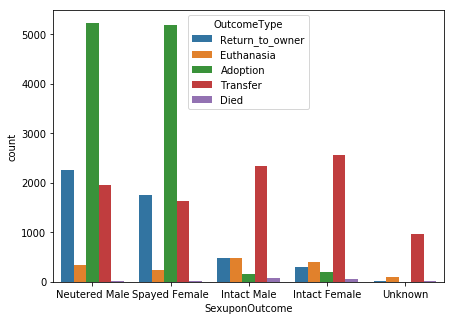

In [15]:
%matplotlib inline
#SexuponOutcome과 결과값 관게 그래프
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(ax = ax, x = 'SexuponOutcome', hue = 'OutcomeType', data = data_train)
plt.show()

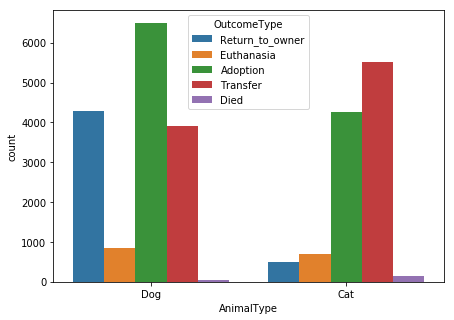

In [16]:
#AnimalType (개 or 고양이)과 결과값 관계 그래프 
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x = 'AnimalType', hue = 'OutcomeType', data = data_train)
plt.show()

#### Reference: https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot

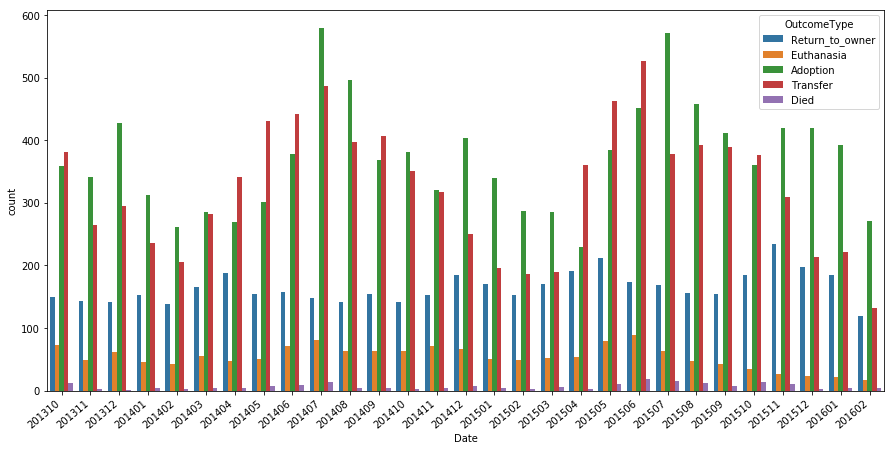

In [17]:
#날짜와 결과값 관계 그래프
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(x = 'Date', hue = 'OutcomeType', data = data_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### 보기 매우 피곤한 그래프이기 때문에 위 Reference에서 나온 factorplot 이용하여 새로운 plot형성

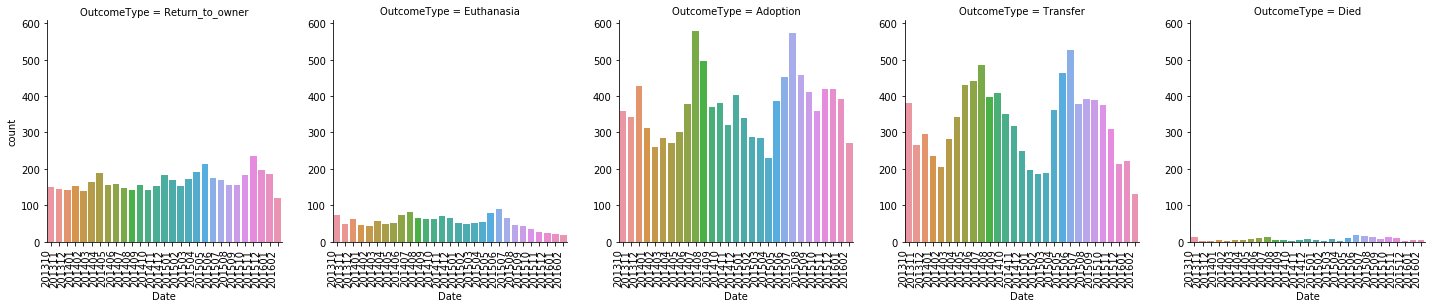

In [18]:
plt.figure(figsize=(20,20))
ax2 = sns.factorplot(x = 'Date', col = 'OutcomeType', data = data_train, kind = 'count')
ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

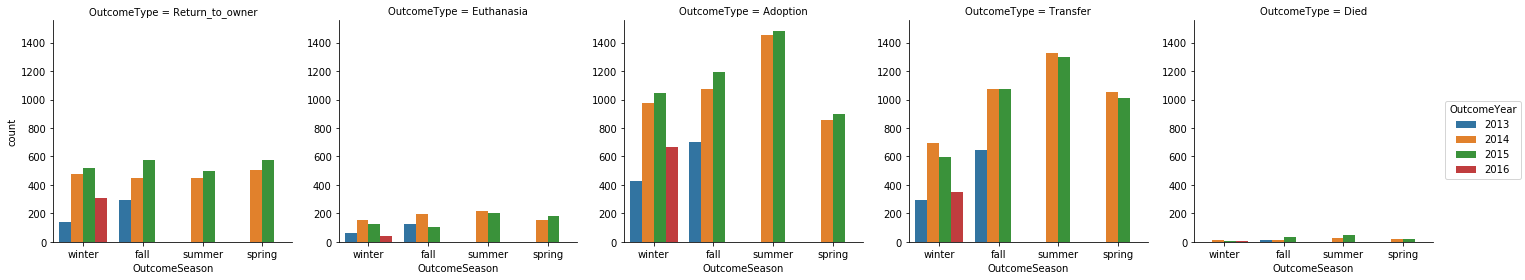

In [19]:
#계절별 OutcomeType 관계 그래프
sns.factorplot(x = 'OutcomeSeason', hue = 'OutcomeYear', col = 'OutcomeType', data = data_train, kind = 'count')
plt.show()

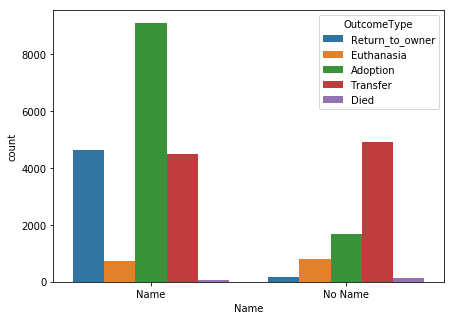

In [20]:
#이름 유/무와 OutcomeType 관계 그래프
plt.figure(figsize = (7, 5))
sns.countplot(x = 'Name', hue = 'OutcomeType', data = data_train)
plt.show()

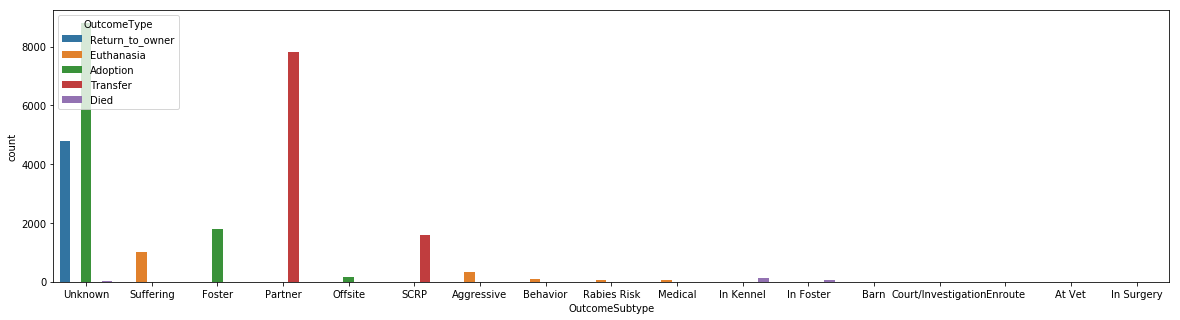

In [21]:
#OutcomeSubType과 OutcomeType 관계 그래프
plt.figure(figsize = (20, 5))
sns.countplot(x = 'OutcomeSubtype', hue = 'OutcomeType', data = data_train)
plt.show()

#### OutcomeSubtype의 경우 OutcomeType과 강한 직관성이 있는것으로 확인

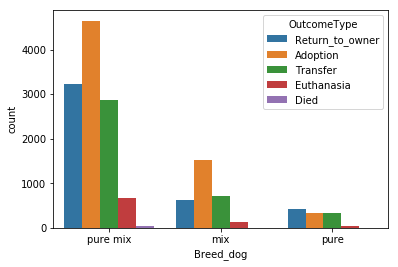

In [22]:
#순종/잡종 개와 OutcomeType 관계 그래프
sns.countplot(x = 'Breed_dog', hue = 'OutcomeType', data = breed_df_dog)
plt.show()

#### 순종견 (Pure)는 갯수가 많지 않기 때문에 Pure mix와 Pure는 같은 종으로 고려함 (타 Kaggle 분석에서도 이런식으로 진행한것 확인)

### 5) 개종을 Size로 변환. Breed의 Unique값 분석결과 1200종이 넘는것으로 확인됨. 이러한 data를 그래로 사용할 경우 Overfitting등의 문제가 있기 때문에 2가지 방법으로 접근할 예전
  
1) 순종 Breed에 관해서는 Size로 변환 -> 잡종일 경우 유전적 factor에 의해서 크기 예측이 쉽지 않음. 이 작업을 수작업으로 하기에는 너무 많은 시간이 소요가 되기 때문에 방법 탐색중 순종을 크기 별로 나눠놓은 웹사이트 발견 -> Crawling

Mixed Breed Reference: http://www.vetstreet.com/our-pet-experts/can-you-predict-the-adult-size-of-a-mixed-breed-puppy

Size Reference : http://www.dogbreedslist.info/herding-dog-breeds/#.WgfCyMZl-iN

2) 또다른 방법은 Breed를 Main breed와 Sub breed열로 나눠서 분석

#### Size별 정보 Crawling (BeautifulSoup)

In [23]:
def size_crawler(url, selector):
    '''This is one of the two functions used for crawlign cat/dog size'''
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    breed_list = soup.select(selector)
    compile_list = []
    for breed in breed_list:
        compile_list.append(breed.get_text().lower())
    return compile_list

def size_compile(url_list, selector):
    '''This is the second functions used for crawlign cat/dog size'''
    list_compile = []
    for url in url_list:
        crawler_list = size_crawler(url, selector)
        list_compile += crawler_list
    return list_compile

In [24]:
'''This section is for crawling the dog size list'''

'''Extract list of dogs for different sizes'''
small_url_list = ['http://www.dogbreedslist.info/small-dog-breeds/list_2_1.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_2.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_3.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_4.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_5.html#.Wfx1Mmi0NPY',
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_6.html#.Wfx1Mmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
small_dog_compile = size_compile(small_url_list, selector)

medium_url_list = ['http://www.dogbreedslist.info/medium-dog-breeds/list_3_1.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_2.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_3.html#.Wfx3bmi0NPY', 
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_4.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_5.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_6.html#.Wfx3bmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
medium_dog_compile = size_compile(medium_url_list, selector) + ['treeing cur', 'treeing tennesse brindle']

large_url_list = ['http://www.dogbreedslist.info/large-dog-breeds/list_4_1.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_2.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_3.html#.Wfx9nWi0NPY', 
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_4.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_5.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_6.html#.Wfx9nWi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
large_dog_compile = size_compile(large_url_list, selector) + ['schnauzer giant', 'olde english bulldogge']

giant_url_list = ['http://www.dogbreedslist.info/giant-dog-breeds/list_5_1.html#.Wfx9nWi0NPY',]

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
giant_dog_compile = size_compile(giant_url_list, selector)

In [25]:
print(medium_dog_compile)

['labrador retriever', 'bulldog', 'poodle', 'boxer', 'siberian husky', 'australian shepherd', 'brittany', 'english springer spaniel', 'american cocker spaniel', 'vizsla', 'weimaraner', 'miniature american shepherd', 'border collie', 'basset hound', 'shiba inu', 'belgian malinois', 'soft coated wheaten terrier', 'portuguese water dog', 'australian cattle dog', 'airedale terrier', 'english cocker spaniel', 'bull terrier', 'whippet', 'shar-pei', 'german wirehaired pointer', 'samoyed', 'wirehaired pointing griffon', 'chow chow', 'american staffordshire terrier', 'staffordshire bull terrier', 'standard schnauzer', 'nova scotia duck tolling retriever', 'basenji', 'tibetan terrier', 'norwegian elkhound', 'wire fox terrier', 'belgian tervuren', 'boykin spaniel', 'lagotto romagnolo', 'pointer', 'american eskimo dog', 'welsh springer spaniel', 'bearded collie', 'kerry blue terrier', 'treeing walker coonhound', 'berger picard', 'redbone coonhound', 'clumber spaniel', 'german pinscher', 'field spa

### 6) 필요없는 feature 제거

In [26]:
data_train.drop('AnimalID', axis = 1, inplace = True)

In [27]:
data_train.drop('DateTime', axis = 1, inplace = True)

In [28]:
data_train.tail()

,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
26724,No Name,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring
26725,No Name,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter
26726,Name,Adoption,Unknown,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring
26727,No Name,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring
26728,No Name,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer


### 7) OutcomeType 심층분석?

In [29]:
def count_outcome(data_train):
    plt.figure()
    outcome = data_train['OutcomeType'].value_counts()
    outcome.plot(kind = 'bar', title = 'Outcome variable count')
    plt.show()

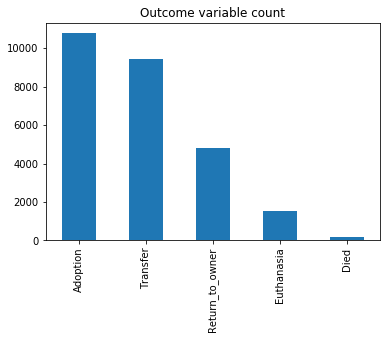

In [30]:
count_outcome(data_train)

Adoption이나 Transfer대비 Euthanasia나 Died 데이터 수가 적음. 이러한 Imbalance가 모델 정확도에 영향을 줄 것으로 예상됨.

### 8) Name 인자 숫자 Preprocessing

#### Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb

In [31]:
def no_name_numeric_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    '''This function is used in conjunction with .transform() method to convert Name and No Name 
    to numerical values'''
    if x == 'No Name':
        return 0
    else:
        return 1

In [32]:
data_train['Name'] = data_train['Name'].transform(no_name_numeric_label)

In [33]:
data_train.tail()

,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
26724,0,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring
26725,0,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter
26726,1,Adoption,Unknown,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring
26727,0,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring
26728,0,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer


### 9) OutcomeSubtype 인코딩 -> 숫자로 mapping 할 계획이었으나 나중에 나올 get_dummies 함수 때문에 필요없어짐

In [34]:
data_train['OutcomeSubtype'].unique()

array(['Unknown', 'Suffering', 'Foster', 'Partner', 'Offsite', 'SCRP',
       'Aggressive', 'Behavior', 'Rabies Risk', 'Medical', 'In Kennel',
       'In Foster', 'Barn', 'Court/Investigation', 'Enroute', 'At Vet',
       'In Surgery'], dtype=object)

In [35]:
def convert_subtype(data_train):
    '''Convert OutcomeSubtype into numerical values'''
    subtype_unique = list(data_train['OutcomeSubtype'].unique())
    subtype_mapping = {}
    for i, item in enumerate(subtype_unique):
        if item == 0:
            continue
        else:
            subtype_mapping[item] = i
    data_train['OutcomeSubtype'] = data_train['OutcomeSubtype'].map(subtype_mapping)
    return data_train, subtype_mapping

In [36]:
#data_train, outComeSubtype_mapping = convert_subtype(data_train)

In [37]:
#data_train['OutcomeSubtype'] = data_train['OutcomeSubtype'].fillna(0)

In [38]:
#data_train.tail()

In [39]:
data_train.shape

(26729, 14)

### 10) NaN값 갯수 분석 및 dropna()적용

In [40]:
data_train.isnull().sum()

Name               0
OutcomeType        0
OutcomeSubtype     0
AnimalType         0
SexuponOutcome     1
AgeuponOutcome    18
Breed              0
Color              0
Date               0
OutcomeYear        0
OutcomeMonth       0
OutcomeDay         0
OutcomeHour        0
OutcomeSeason      0
dtype: int64

#### NaN값 갯수가 적기 때문에 그냥 drop하는 방향으로 결정. test.csv 자료에 NaN값이 있을 경우 mean 또는 mode값으로 대체

In [41]:
data_train = data_train.dropna()
data_train.shape

(26710, 14)

### 11) Animal mapping -> 개는 1, 고양이는 0으로 전처리

In [42]:
animal_type_mapping = {'Dog':1, 'Cat':0}
data_train['AnimalType'] = data_train['AnimalType'].map(animal_type_mapping)

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 12) 결과값 'OutcomeType' 전처리 -> Animal mapping과 동일한 방법으로 .map()함수를 이용하여 전처리 진행

In [43]:
outcome_mapping = {'Return_to_owner':1, 'Euthanasia':2, 'Adoption':3, 'Transfer':4, 'Died':5}
data_train['OutcomeType'] = data_train['OutcomeType'].map(outcome_mapping)

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 13) AgeUponOutcome 데이터를 모두 일(day)로 변환

#### Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string

In [44]:
'''This section of the code is used to check the unique string values that are present in the AgeuponOutcome column'''
age_list_compile = []
age_outcome_list = list(data_train['AgeuponOutcome'])
for item in age_outcome_list:
    if type(item) != str:
        '''This condition is to account for NaN values'''
        continue
    result = ''.join(i for i in item if not i.isdigit())
    age_list_compile.append(result)
'''We can check unique string values in the column'''
age_list_unique = list(pd.Series(age_list_compile).unique())
print(age_list_unique)
'''This list contains year(s), month(s), week(s), day(s)'''

[' year', ' years', ' weeks', ' month', ' months', ' days', ' week', ' day']


'This list contains year(s), month(s), week(s), day(s)'

#### age_list_unique 리스트 확인결과 year, years, month, months, week, weeks, day, days의 유니크한 값을 가짐. 나이관련 변수 단위를 일(day)로 통일

In [45]:
def convert_Age(data_train):
    '''Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string'''
    '''This function convert all the time into unit of day'''
    age_list = list(data_train['AgeuponOutcome'])
    age_day_compile = []
    for item in age_list:
        if type(item) != str:
            age_day_compile.append(item)
        else:
            numeric = int(item[:2])
            if 'year' in item:
                age_day_compile.append(numeric * 365)
            elif 'month' in item:
                age_day_compile.append(numeric * 30)
            elif 'week' in item:
                age_day_compile.append(numeric * 7)
            elif 'day' in item:
                age_day_compile.append(numeric)
    return age_day_compile 

In [46]:
age_day_compile = convert_Age(data_train)
data_train['AgeuponOutcome'] = age_day_compile

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 14) 순종 Mix와 순종을 같은 Breed로 설정

In [47]:
def remove_mix(data_train):
    '''This function removes the keyword mix from breed list. The result from
    this method is used when converting breed into different categories'''
    breed_list = list(data_train['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            item = item[:-4]
        breed_compile.append(item)
    return breed_compile

In [48]:
breed_remove_mix = remove_mix(data_train)

### 15) train.csv에 있는 모든 견종이 Crawling한 list에 존재하나 줄임말 또는 표기법이 달라서 인식이 안되는 종이 30종 정도 있는것으로 확인하였음 . 종이 그렇게 많지 않기 때문에 노가다 작업진행

In [49]:
for index, item in enumerate(breed_remove_mix):
    if item == 'chihuahua shorthair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'collie smooth':
        breed_remove_mix[index] = 'collie'
    elif item == 'anatol shepherd':
        breed_remove_mix[index] = 'anatolian shepherd dog'
    elif item == 'port water dog':
        breed_remove_mix[index] = 'portuguese water dog'
    elif item == 'flat coat retriever':
        breed_remove_mix[index] = 'flat-coated retriever'
    elif item == 'pbgv':
        breed_remove_mix[index] = 'petit basset griffon vendeen'
    elif item == 'bruss griffon':
        breed_remove_mix[index] = 'brussels griffon'
    elif item == 'bluetick hound':
        breed_remove_mix[index] = 'bluetick coonhound'
    elif item == 'wire hair fox terrier':
        breed_remove_mix[index] = 'wire fox terrier'
    elif item == 'dachshund wirehair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'rhod ridgeback':
        breed_remove_mix[index] = 'rhodesian ridgeback'
    elif item == 'picardy sheepdog':
        breed_remove_mix[index] = 'berger picard'
    elif item == 'st. bernard rough coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item == 'old english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'chesa bay retr':
        breed_remove_mix[index] = 'chesapeake bay retriever'
    elif item == 'dachshund longhair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'chihuahua longhair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'chinese sharpei':
        breed_remove_mix[index] = 'shar-pei'
    elif item == 'standard poodle':
        breed_remove_mix[index] = 'poodle'
    elif item == 'bull terrier miniature':
        breed_remove_mix[index] = 'miniature bull terrier'
    elif item =='st. bernard smooth coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item =='redbone hound':
        breed_remove_mix[index] = 'redbone coonhound'
    elif item == 'cavalier span':
        breed_remove_mix[index] = 'cavalier king charles spaniel'
    elif item == 'collie rough':
        breed_remove_mix[index] = 'collie'
    elif item == 'german shorthair pointer':
        breed_remove_mix[index] = 'german shorthaired pointer'
    elif item == 'english pointer':
        breed_remove_mix[index] = 'pointer'
    elif item == 'mexican hairless':
        breed_remove_mix[index] = 'xoloitzcuintli'
    elif item =='dogo argentino':
        breed_remove_mix[index] = 'argentine dogo'
    elif item == 'queensland heeler':
        breed_remove_mix[index] = 'australian cattle dog'

### 16) 고양이 사이즈 -> 고양이는 종류가 강아지만큼 다양하지 않기 때문에 수작업 전처리 진행

In [50]:
small_cat_list = ['munchkin longhair']
medium_cat_list = ['exotic shorthair', 'persian', 'abyssinian', 'sphynx', 'siamese',
                   'cornish rex', 'devon rex', 'burmese', 'tonkinese', 'russian blue', 
                   'manx', 'japanese bobtail', 'balinese', 'bombay', 'havana brown',
                   'bengal', 'cymric', 'himalayan', 'snowshoe', 'javanese', 'havana brown', 'angora']
large_cat_list = ['american shorthair', 'british shorthair', 'norwegian forest cat', 'ocicat',
                  'turkish van', 'pixiebob shorthair', 'maine coon', 'ragdoll']
domestic = ['domestic longhair', 'domestic medium hair', 'domestic shorthair']

고양이종에 domestic이 붙은 종은 북미지역에 서식하는 잡종 고양이를 뜻함. train 데이터에서도 압도적으로 많은 고양이들이 domestic 종이고 실제로도 북미지역 애완 고양이는 높은 비율로 domestic 잡종인것을 아래 참조 자료를 통해 확인하였음. 잡종인 만큼 size를 예측하기 힘들기 때문에 domestic이라는 카테고리를 따로 형성함. 내용은 아래 Reference 참고.

#### Reference: http://www.petguide.com/breeds/cat/domestic-longhair/

### 17) 개/고양이 Size 인자형성

#### Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings

In [51]:
def convert_breed(type_list, breed_list, small_list, medium_list, large_list, giant_list,
                  small_cat_list, medium_cat_list, large_cat_list, domestic_cat_list):
    '''Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings
    that is a really smart and succinct solution for checking substring existence in a list of strings'''
    
    '''The incoming list a list of breeds with the keyword "mix" removed and converted
    to lower case. No need for extra preprocessing. Also the dog lists are all converted
    to lower case as well. Type list is to check whether the breed belongs to dog or cat'''
    if len(type_list) != len(breed_list):
        print('Two lists must have equal length!')
        return None
    
    '''Convert the list into a string format for easier processing'''
    small_combined = '\t'.join(small_list)
    medium_combined = '\t'.join(medium_list)
    large_combined = '\t'.join(large_list)
    giant_combined = '\t'.join(giant_list)
    
    breed_compile, excluded_list, mix_breed_list, cat_breed_list = [], [], [], []
    for animal_type, breed in zip(type_list, breed_list):
        if '/' in breed: #Mixed type categorization
            mix_breed_list.append(breed)
            breed_compile.append('mix')
        elif animal_type == 0: #Cat breed categorization
            cat_breed_list.append(breed)
            if breed in small_cat_list:
                breed_compile.append('small_cat')
            elif breed in medium_cat_list:
                breed_compile.append('medium_cat')
            elif breed in large_cat_list:
                breed_compile.append('large_cat')
            elif breed in domestic_cat_list:
                breed_compile.append('domestic')
        elif animal_type == 1: #Dog breed categorization
            if breed in small_combined:
                breed_compile.append('small')
            elif breed in medium_combined:
                breed_compile.append('medium')
            elif breed in large_combined:
                breed_compile.append('large')
            elif breed in giant_combined:
                breed_compile.append('giant')
            else:
                excluded_list.append(breed)
                breed_compile.append('unknown')
    return breed_compile, excluded_list, mix_breed_list, cat_breed_list

In [1]:
'''Compare the breed in the data to crawled size lists and create a list indicating
the size of each breed. By zipping two lists, we can also ignore species that
belong to cats. Some breed names were manually modified to fit the crawled list'''
type_list = list(data_train['AnimalType'])

convert_list, excluded_list_dog, mix_breed_list_dog, cat_breed_list = convert_breed(type_list, 
                                     breed_remove_mix, small_dog_compile, 
                                     medium_dog_compile, large_dog_compile, giant_dog_compile,
                                     small_cat_list, medium_cat_list, large_cat_list, domestic)

'''With the manual correction to dog breed, this list should only contain unknown values'''
excluded_unique_dog = list(set(excluded_list_dog))
print(excluded_unique_dog)

NameError: name 'data_train' is not defined

In [53]:
'''Whew finally add the cleansed convert_dog_list to our data_train DataFrame'''
data_train['Size'] = convert_list
data_train.tail()

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size
26724,0,4,Partner,0,Intact Male,30,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring,domestic
26725,0,4,SCRP,0,Spayed Female,90,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter,domestic
26726,1,3,Unknown,1,Neutered Male,1460,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring,large
26727,0,4,Partner,0,Intact Male,28,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring,domestic
26728,0,4,SCRP,0,Intact Male,365,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer,domestic


#### Size column에 우리가 예상하는 값만 있는지 확인

In [54]:
'''Confirm that only expected values small, medium, large, giant, unknown and domestic
are present in the Size column'''
size_check_list = list(data_train['Size'].unique())

In [55]:
print(size_check_list)

['small', 'domestic', 'medium', 'mix', 'giant', 'medium_cat', 'large', 'large_cat', 'unknown', 'small_cat']


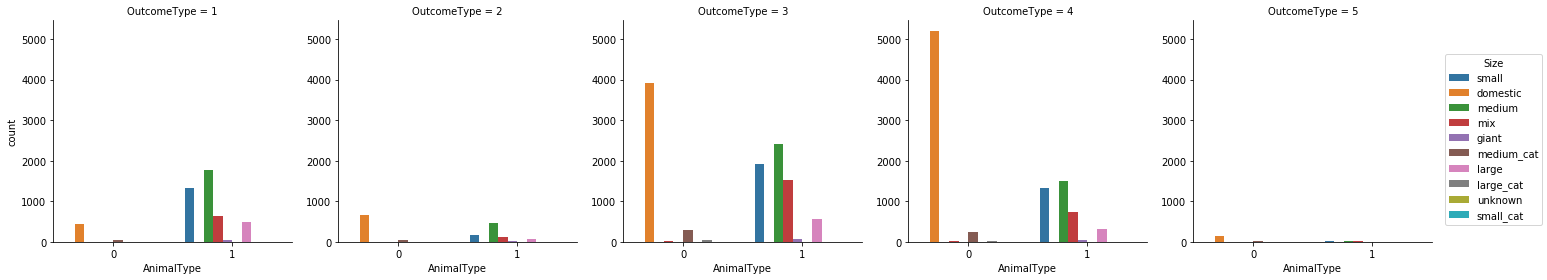

In [56]:
sns.factorplot(x = 'AnimalType', hue = 'Size', col = 'OutcomeType', data = data_train, kind = 'count')

#### 고양이 경우 앞서 말했듯이 domestic종이 다른 종에 비해 압도적으로 많은 것으로 확인됨. 따라서 차후 머신러닝 알고리즘 적용시 고양이와 개의 분류는 AnimalType에 의해서 이루어 질지 아니면 domestic이라는 종에 의해서 이루어 질지 확인해볼 필요가 있음

#### 완변하진 않지만 각각 결과값에 따른 애완견 사이즈별 비율이 비슷한 형태를 하고 있는것으로 판단됨. 어쩌면 size가 생각보다 중요하지 않은 인자일수도? 

### 18) Breed와 Color를 Main과 Sub 그룹으로 각각 나누는 작업

#### 우선 잡종중에서 3개 이상의 종이 섞인 케이스가 몇개인지 판단

In [57]:
check_breed = list(data_train['Breed'])
count = 0
for item in check_breed:
    if item.count('/') == 2:
        count += 1
print(count)

10


#### 10개밖에 없기때문에 잡종일 경우 main과 sub로만 분리 (원래 계획은 sub1, sub2로 나눌 계획이었음)

In [58]:
def breed_separator(breed_remove_mix):
    '''This function separates the breed into main and sub breed columns'''
    main_breed, sub_breed = [], []
    for breed in breed_remove_mix:
        if breed.count('/') == 0:
            main_breed.append(breed)
            sub_breed.append('NA')
        elif breed.count('/') == 1 or breed.count('/') == 2:
            temp_breed_list = breed.split('/')
            main_breed.append(temp_breed_list[0])
            sub_breed.append(temp_breed_list[1])
    return main_breed, sub_breed

In [59]:
main_breed, sub_breed = breed_separator(breed_remove_mix)
data_train['Main_Breed'], data_train['Sub_Breed'] = main_breed, sub_breed

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
def color_separator(color_list):
    '''The function separates color into main and sub colors'''
    main_color, sub_color = [], []
    for color in color_list:
        if color.count('/') == 0:
            main_color.append(color)
            sub_color.append('NA')
        elif color.count('/') == 1:
            temp_color_list = color.split('/')
            main_color.append(temp_color_list[0])
            sub_color.append(temp_color_list[1])
    return main_color, sub_color

In [61]:
color_list = list(data_train['Color'])
main_color, sub_color = color_separator(color_list)
data_train['Main_Color'], data_train['Sub_Color'] = main_color, sub_color

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### 생각해 보니 그냥 main_sub_separator라는 동일 함수를 작성하면 되는거였는데...........

In [62]:
# 데이터 확인
data_train.tail()

,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
26724,0,4,Partner,0,Intact Male,30,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring,domestic,domestic shorthair,NA,Brown Tabby,White
26725,0,4,SCRP,0,Spayed Female,90,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter,domestic,domestic shorthair,NA,Brown Tabby,NA
26726,1,3,Unknown,1,Neutered Male,1460,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring,large,olde english bulldogge,NA,White,Tan
26727,0,4,Partner,0,Intact Male,28,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring,domestic,domestic shorthair,NA,Black,NA
26728,0,4,SCRP,0,Intact Male,365,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer,domestic,domestic shorthair,NA,Brown Tabby,White


### 19) 애완견 랭킹

#### Reference: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

애완견을 2013, 2014, 2015년 순서로 가장 인기 랭킹을 mapping한 인자를 형성. mapping 코드는 위 첨부자료에서 가지고 옴.

2013, 2014, 2015 랭킹을 보면 순위가 크게 변동하지 않는것이 보임. Size 크롤링한 웹사이트에 있는 2016년 랭킹을 크롤링해서 feature engineering작업 진행함

In [ ]:
# 2015 Breed Popularity Calculation
breed_popularity_scores_2015 = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
                                '16', '17', '18', '19',
                                '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
                                '34', '35', '36', '37',
                                '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '50',
                                '51', '52', '53', '54',
                                '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68',
                                '69', '70', '71', '72',
                                '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86',
                                '87', '88', '89', '90',
                                '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103',
                                '104', '105', '106', '107',
                                '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119',
                                '120', '121', '122',
                                '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134',
                                '135', '136', '137',
                                '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149',
                                '150', '151', '152',
                                '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164',
                                '165', '166', '167',
                                '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179',
                                '180', '181', '182',
                                '183', '184']

breed_popularity_2015 = pd.DataFrame(animal_breeds)
breed_popularity_2015['Breed11'] = pd.DataFrame(animal_breeds)
breed_popularity_2015['Breed_Popularity_2015'] = pd.DataFrame(breed_popularity_scores_2015)
breed_popularity_2015.drop(0, axis=1, inplace=True)
breed_popularity_2015['Breed11'] = breed_popularity_2015['Breed11'].str.upper()

# Joining Breeds Popularity Scores to the dataset depending on the breeds
data_set = pd.merge(data_set, breed_popularity_2015, on='Breed11', how='left')

data_set['Breed_Popularity_2015'] = data_set['Breed_Popularity_2015'].fillna(-9999).astype(float)

### 20) get_dummies를 이용한 one hot encoding

#### pandas의 get_dummies 함수를 사용하면 string값으로 되어있는 데이터를 one hot encoding 해줄뿐만 아니라 column name까지 깔끔하게 처리해준다!

In [63]:
main_color_le = pd.get_dummies(data_train[['Main_Color']])
sub_color_le = pd.get_dummies(data_train[['Sub_Color']])
main_breed_le = pd.get_dummies(data_train[['Main_Breed']])
sub_breed_le = pd.get_dummies(data_train[['Sub_Breed']])
year_le = pd.get_dummies(data_train[['OutcomeYear']])
month_le = pd.get_dummies(data_train[['OutcomeMonth']])
day_le = pd.get_dummies(data_train[['OutcomeDay']])
hour_le = pd.get_dummies(data_train[['OutcomeHour']])
size_le = pd.get_dummies(data_train['Size'])
sex_le = pd.get_dummies(data_train['SexuponOutcome'])
season_le = pd.get_dummies(data_train[['OutcomeSeason']])
outcomesubtype_le = pd.get_dummies(data_train[['OutcomeSubtype']])

#### get_dummies가 적용된 feature 예제 

In [64]:
year_le.head()

,OutcomeYear_2013,OutcomeYear_2014,OutcomeYear_2015,OutcomeYear_2016
0,0,1,0,0
1,1,0,0,0
2,0,0,1,0
3,0,1,0,0
4,1,0,0,0


In [65]:
size_le.head()

,domestic,giant,large,large_cat,medium,medium_cat,mix,small,small_cat,unknown
0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [66]:
sex_le.head()

,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [67]:
outcomesubtype_le.head()

,OutcomeSubtype_Aggressive,OutcomeSubtype_At Vet,OutcomeSubtype_Barn,OutcomeSubtype_Behavior,OutcomeSubtype_Court/Investigation,OutcomeSubtype_Enroute,OutcomeSubtype_Foster,OutcomeSubtype_In Foster,OutcomeSubtype_In Kennel,OutcomeSubtype_In Surgery,OutcomeSubtype_Medical,OutcomeSubtype_Offsite,OutcomeSubtype_Partner,OutcomeSubtype_Rabies Risk,OutcomeSubtype_SCRP,OutcomeSubtype_Suffering,OutcomeSubtype_Unknown
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Feature Selection

#### Feature Preprocessing 마침. 생각보다 간단한 데이터 구조였슴에도 불구하고 데이터 전처리가 어마어마한 분량을 차지하고 있다.

In [68]:
def greedy_selector(dfX_list, dfY):
    '''This function performs greedy feature selection. dfX_list contains various combinations of features that will be used'''
    train_compile, test_compile, logLoss_compile = [], [], []
    
    for dfX in dfX_list:
        dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX, dfY, test_size = 0.25, random_state=0)
        '''nthread parameter is the paralleization parameter. This forces XGBoost to utilize all the CPU power available'''
        model_xgb = xgboost.XGBClassifier(n_estimators = 100, max_depth = 2, nthread = 3)
        model_xgb.fit(dfX_train, dfY_train)

        '''Let us save train and test accuracy along with log loss'''
        y_pred_train = model_xgb.predict(dfX_train)
        train_accuracy = accuracy_score(dfY_train, y_pred_train)
        train_compile.append(train_accuracy)

        y_pred_test = model_xgb.predict(dfX_test)
        test_accuracy = accuracy_score(dfY_test, y_pred_test)
        test_compile.append(test_accuracy)

        y_proba = model_xgb.predict_proba(dfX_test)
        logLoss = log_loss(dfY_test, y_proba)
        logLoss_compile.append(logLoss)
        
    return train_compile, test_compile, logLoss_compile

Feature Selection은 원래 feature_importance할 예정이었으나 위에 get_dummies method를 통해 본 결과 인자수가 어마어마 하다는것을 알수있다 (대략 530개 정도). 또한 인자끼리 관계도 또한 무시할수 없기 때문에 고민하던중, 우선 XGBoost를 이용해서 Greedy 한 방식으로 feature selection을 진행하기로 했다. 정식대로라면 사용하려는 feature마다 모델 최적화를 하면서 결과값을 비교하는것이 정상이지만 그렇게 할려하니 시간도 오래 걸리고 해서 차선책으로 Greedy방식으로 진행 해보기로 했다.

In [69]:
%%time
'''dfY is always fixed'''
dfY = data_train['OutcomeType']

dummy_cont = data_train[['Name', 'AnimalType', 'AgeuponOutcome']]

dfX = pd.concat([dummy_cont, main_breed_le, main_color_le, month_le, year_le, sex_le], axis = 1)
dfX2 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX3 = pd.concat([dummy_cont, size_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX4 = pd.concat([dummy_cont, size_le, main_breed_le, sub_breed_le, main_color_le, sub_color_le, month_le, year_le, sex_le], axis = 1)
dfX5 = pd.concat([dummy_cont, main_breed_le, sub_breed_le, main_color_le, sub_color_le, season_le, sex_le], axis = 1)
dfX6 = pd.concat([dummy_cont, size_le, main_breed_le, sub_breed_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le], axis = 1)
dfX7 = pd.concat([dummy_cont, size_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le], axis = 1)
dfX8 = pd.concat([dummy_cont, size_le, main_breed_le, sub_breed_le, main_color_le, sub_color_le, 
                 year_le, month_le, day_le, hour_le, sex_le, outcomesubtype_le], axis = 1)

dfX_list = [dfX, dfX2, dfX3, dfX4, dfX5, dfX6, dfX7, dfX8]
train_compile, test_compile, logLoss_compile = greedy_selector(dfX_list, dfY)

Wall time: 3min 57s


In [70]:
print('Test accuracy: ', test_compile)
print('Log Loss performance: ', logLoss_compile)

Test accuracy:  [0.64315663372267151, 0.64315663372267151, 0.64405510631925722, 0.64585205151242886, 0.6428571428571429, 0.66172506738544479, 0.66142557651991618, 0.87840670859538783]
Log Loss performance:  [0.85800700819587838, 0.85758618275654752, 0.85924829561045768, 0.85612845543925953, 0.85740930187245634, 0.8220473120553019, 0.82509410100721003, 0.25363472740947013]


Text(0.5,1,'Greedy Feature Selection Result')

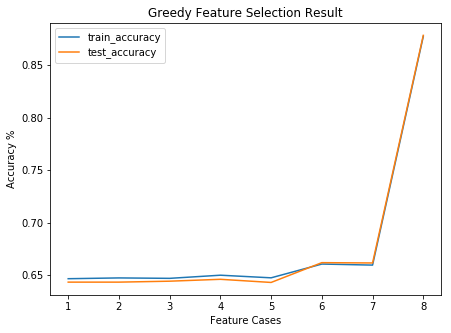

In [71]:
plt.figure(figsize = (7, 5))
plt.plot(range(1, 9), train_compile, label = 'train_accuracy')
plt.plot(range(1, 9), test_compile, label = 'test_accuracy')
plt.legend()
plt.xlabel('Feature Cases')
plt.ylabel('Accuracy %')
plt.title('Greedy Feature Selection Result')

Text(0.5,1,'Greedy Feature Selection Result')

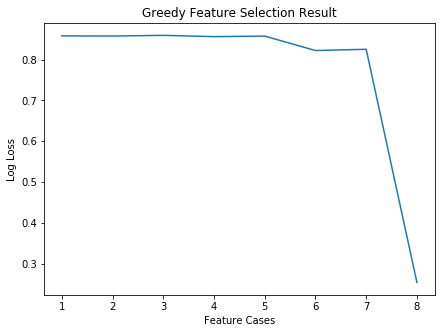

In [72]:
plt.figure(figsize = (7, 5))
plt.plot(range(1, 9), logLoss_compile)
plt.xlabel('Feature Cases')
plt.ylabel('Log Loss')
plt.title('Greedy Feature Selection Result')

#### OutcomeSubtype 첨부시 모델 정확도가 급증가 하는것으로 파악됨. 모델 최적화 없이도 Kaggle점수 2등 수준의 점수가 나오지만 test.csv에는 OutcomeSubtype이 없으며 실제 결과와 너무 직관적으로 연관된 인자라 사용 X (Case 7번)

#### 나머지 인자 비교시, 다른 인자보다 DateTime의 Day, Hour정보 첨부시 정확도와 log loss 값이 많이 올라가는것이 보임 (Case 6번)

## XGBoost Model Optimization

#### Max depth와 n_estimator를 한번에 할수있는 GridSearchCV를 적용하여 최적 모델 검증진행

In [118]:
dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX6, dfY, test_size = 0.25, random_state=0, stratify = dfY)

### XGBoost: GridSearchCV 최적화 방안 2

#### References: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

#### XGBoost Parameter Tuning: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

원래 계획은 max_depth와 n_estimator를 한번에 GridSearchCV를 통한 최적화. 하지만 Runtime시간도 너무 길고 여러가지 튜닝을 하는데 시간적 한계가 있는것으로 판단되어서 차선책을 찾던중 좋은 방안 찾아냄.

한개의 모델을 최적화 하는 것 보다 max_depth값을 변환하면서 예측한 결과를 바탕으로 평균성능을 뽑아내는 것이 더 잘 나온다는 참조 정보를 바탕으로 진행해봄. 모델 인자 튜닝 또한 윗 참조에서 사용한 값 적용.

learning_rate = Overfitting 방지용 parameter

subsample = default값은 1. 각 트리 형성시 사용하는 train data비율. 1보다 낮게 잡을경우 overfitting 방지에 도움되는 파라미터

colsample_bytree = tree 형성시 사용되는 sub column 갯수 조절 인자

In [121]:
model_xgb1 = xgboost.XGBClassifier(max_depth = 6, nthread = -1)
model_xgb2 = xgboost.XGBClassifier(max_depth = 7, nthread = -1)
model_xgb3 = xgboost.XGBClassifier(max_depth = 8, nthread = -1)
model_xgb4 = xgboost.XGBClassifier(max_depth = 9, nthread = -1)
model_xgb5 = xgboost.XGBClassifier(max_depth = 10, nthread = -1)

model_xgb1.fit(dfX_train, dfY_train)
model_xgb2.fit(dfX_train, dfY_train)
model_xgb3.fit(dfX_train, dfY_train)
model_xgb4.fit(dfX_train, dfY_train)
model_xgb5.fit(dfX_train, dfY_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [122]:
y_proba1 = model_xgb1.predict_proba(dfX_test)
y_proba2 = model_xgb2.predict_proba(dfX_test)
y_proba3 = model_xgb3.predict_proba(dfX_test)
y_proba4 = model_xgb4.predict_proba(dfX_test)
y_proba5 = model_xgb5.predict_proba(dfX_test)

y_proba_avg = (y_proba1 + y_proba2 + y_proba3 + y_proba4 + y_proba5) / 5
performance = log_loss(dfY_test, y_proba_avg)
print(performance)

0.769037711847


확실히 모델 하나만 적용하는것 보다 test_size 변화에 덜 민감한 편이다.

### Feature importance 분석

In [94]:
'''Feature importance analysis code'''
'''Reference: Python Machine Learning'''
feat_labels = np.array(dfX6.columns)
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs = 3)
forest.fit(dfX_train, dfY_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:30]

for f in range(len(indices)):
    print("%2d %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]] ))

plt.figure(figsize = (9, 7))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

다른 Kaggle참가자들과 비슷하게 DateTime에서 Year, Month, Day, Hour 결과를 적용할 경우 Breed와 Color인자보다 시간인자들이 더 중요하게 나오는 기이한 현상을 발견할수 있다.  밑에 Kaggle 결과값 논란 부분에서 더 자세하게 언급.

### ROC Curve and AUC score

In [192]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

y_multi = label_binarize(dfY_test, classes=[1, 2, 3, 4, 5])

In [193]:
d1_multi = model_xgb.predict_proba(dfX_test)

In [194]:
fpr10, tpr10, thresholds10 = roc_curve(y_multi[:, 0], d1_multi[:, 0])
fpr11, tpr11, thresholds11 = roc_curve(y_multi[:, 1], d1_multi[:, 1])
fpr12, tpr12, thresholds12 = roc_curve(y_multi[:, 2], d1_multi[:, 2])
fpr13, tpr13, thresholds13 = roc_curve(y_multi[:, 3], d1_multi[:, 3])
fpr14, tpr14, thresholds14 = roc_curve(y_multi[:, 4], d1_multi[:, 4])

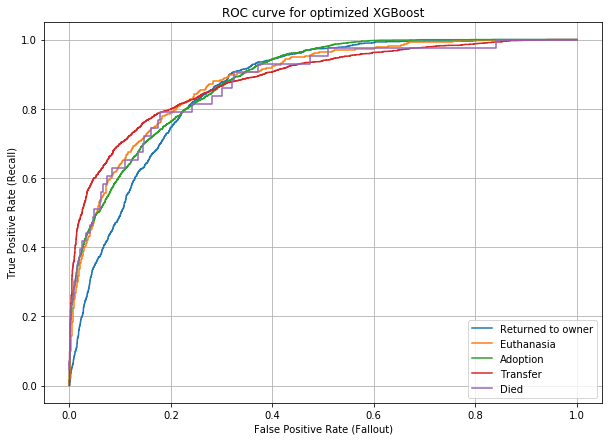

In [201]:
plt.figure(figsize = (10, 7))
plt.plot(fpr10, tpr10, label="Returned to owner")
plt.plot(fpr11, tpr11, label="Euthanasia")
plt.plot(fpr12, tpr12, label="Adoption")
plt.plot(fpr13, tpr13, label="Transfer")
plt.plot(fpr14, tpr14, label="Died")
plt.title('ROC curve for optimized XGBoost')
plt.xlabel('False Positive Rate (Fallout)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid(True)
plt.show()

In [196]:
#AUC
print('AUC for Returned to owner: ', auc(fpr10, tpr10))
print('AUC for Euthanasia: ', auc(fpr11, tpr11))
print('AUC for Adoption: ', auc(fpr12, tpr12))
print('AUC for Transfer: ', auc(fpr13, tpr13))
print('AUC for Died: ', auc(fpr14, tpr14))

AUC for Returned to owner:  0.861225478923
AUC for Euthanasia:  0.881810024093
AUC for Adoption:  0.882836413447
AUC for Transfer:  0.886420876912
AUC for Died:  0.875410525578


## Logistic Regression Model Optimization

In [149]:
def lr_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_lr = LogisticRegression()
    parameters = {'penalty': ['l1','l2'], 'C': [0.01, 0.1, 1, 10,100]}
    
    gs = GridSearchCV(estimator = model_lr, param_grid = parameters, scoring = 'neg_log_loss', cv = 10, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [150]:
gs = lr_optimizer_estimator(dfX_train, dfY_train)

Wall time: 1min 42s


In [151]:
gs.cv_results_["mean_test_score"]

array([-0.92015467, -0.89323221, -0.86267595, -0.86179023, -0.85928756,
       -0.86032732, -0.88112314, -0.86329438, -0.91116084, -0.86432525])

In [152]:
print(gs.best_score_)
print(gs.best_params_)

-0.859287560118
{'C': 1, 'penalty': 'l1'}


### Logistic Regression: GridSearchCV 최적화 식 최종 test 검증

In [153]:
model_lr = LogisticRegression(penalty = 'l1', C = 1)
model_lr.fit(dfX_train, dfY_train)

y_pred_train = model_lr.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_lr.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_lr.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [154]:
print('Logistic Regression -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

Logistic Regression -----> Training accuracy: 0.664406,  Test accuracy: 0.641378,  log_loos:  0.871613


In [155]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          1       0.48      0.35      0.40       718
          2       0.55      0.08      0.14       233
          3       0.64      0.85      0.73      1615
          4       0.71      0.66      0.68      1411
          5       0.00      0.00      0.00        30

avg / total       0.63      0.64      0.62      4007



C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Decision Tree를 기반으로 둔 비선형 XGBoost 모델에 비해 선형 모델인 Logistic Regression은 확실히 정확도가 감소하는것이 확인됨

## Random Forest Model Optimization

GridsearchCV인자는 XGBoost와 동일하게 설정후 최적화 하여 두 모델 성능 비교

In [156]:
def forest_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_forest = RandomForestClassifier(n_jobs = 3)
    parameters = {'max_depth': [35, 40, 45, 50], 'n_estimators': [300, 500, 700]}
    
    gs = GridSearchCV(estimator = model_forest, param_grid = parameters, scoring = 'neg_log_loss', cv = 10, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [157]:
%%time
gs_estimator = forest_optimizer_estimator(dfX_train, dfY_train)

Wall time: 32min 19s
Wall time: 32min 19s


In [158]:
gs_estimator.cv_results_["mean_test_score"]

array([-0.81029833, -0.80856741, -0.80927977, -0.80742586, -0.80460231,
       -0.80469624, -0.80852663, -0.80615042, -0.80333146, -0.820309  ,
       -0.8122254 , -0.80706698])

In [159]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

-0.803331457128
{'max_depth': 45, 'n_estimators': 700}


### Random Forest: GridSearchCV 최적화 식 최종 test 검증

In [164]:
model_forest = RandomForestClassifier(max_depth = 45, n_estimators = 700, n_jobs = 3)
model_forest.fit(dfX_train, dfY_train)

y_pred_train = model_forest.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_forest.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_forest.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [165]:
print('RandomForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

RandomForest -----> Training accuracy: 0.999692,  Test accuracy: 0.668081,  log_loos:  0.807599


In [166]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          1       0.51      0.37      0.43       718
          2       0.65      0.06      0.10       233
          3       0.66      0.86      0.75      1615
          4       0.74      0.72      0.73      1411
          5       0.00      0.00      0.00        30

avg / total       0.66      0.67      0.64      4007



C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


XGBoost와 Logistic Regression의 중간점에 위치한 performance를 보여주고 있다. 특이한 점으로는 최적점 tree_depth가 크다보니 XGBoost대비 train accuracy와 test accuracy의 차이가 큰 것으로 보임

## Extreme Forest Optimization

In [168]:
def exforest_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_forest = ExtraTreesClassifier(n_jobs = 3)
    parameters = {'max_depth': [35, 40, 45, 50], 'n_estimators': [300, 500, 700]}
    
    gs = GridSearchCV(estimator = model_forest, param_grid = parameters, scoring = 'neg_log_loss', cv = 10, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [169]:
%%time
gs_estimator = forest_optimizer_estimator(dfX_train, dfY_train)

Wall time: 28min 58s
Wall time: 28min 58s


In [170]:
gs_estimator.cv_results_["mean_test_score"]

array([-0.81157106, -0.80899721, -0.80849733, -0.80780493, -0.80478246,
       -0.80398026, -0.81111897, -0.80564983, -0.80442919, -0.81591302,
       -0.80860217, -0.80456782])

In [171]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

-0.803980257974
{'max_depth': 40, 'n_estimators': 700}


### Extreme Forest: GridSearchCV 최적화 식 최종 test 검증

In [172]:
model_exforest = ExtraTreesClassifier(max_depth = 40, n_estimators = 700, n_jobs = -1)
model_exforest.fit(dfX_train, dfY_train)

y_pred_train = model_exforest.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_exforest.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_exforest.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [173]:
print('ExtremeForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

ExtremeForest -----> Training accuracy: 0.999692,  Test accuracy: 0.663838,  log_loos:  0.825352


In [174]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          1       0.50      0.31      0.38       718
          2       0.58      0.06      0.11       233
          3       0.65      0.88      0.75      1615
          4       0.74      0.71      0.73      1411
          5       0.00      0.00      0.00        30

avg / total       0.65      0.66      0.63      4007



Random Forest대비 살짝 퍼포먼스가 안좋은 결과가 나왔다. Random Forest와 마찬가지로 최적 Max_depth가 크다 보니 training accuracy 와 test accuracy 차이가 큰 것으로 보인다. XGBoost대비 Random Forest나 Extreme Forest는 검증이 매우 중요한 것으로 판단된다.

## Naive Bayesian Model Optimization

#### Reference: https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

위 참조는 Naive Bayesian모델의 predict_proba 결과는 신용성이 떨어진다는 내용의 관련 자료임

In [110]:
model_NB = GaussianNB().fit(dfX_train, dfY_train)

In [111]:
y_pred_train = model_NB.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_NB.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_NB.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [112]:
print('ExtremeForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

ExtremeForest -----> Training accuracy: 0.169011,  Test accuracy: 0.141146,  log_loos:  25.681830


In [113]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          1       0.32      0.24      0.28      1435
          2       0.07      0.24      0.11       466
          3       0.61      0.12      0.21      3231
          4       0.44      0.08      0.14      2822
          5       0.01      0.71      0.02        59

avg / total       0.46      0.14      0.19      8013



Naive Bayesian의 가정중 하나는 feature들이 독립적인(independence) 관계를 가진다는 거다. 하지만 앞서 EDA에서 봤듯이 shelter animal 데이터는 인자별 관계도가 매우 복잡하다. 어느정도 예상했지만 생각보다 더  Naive Bayesian 접근은 결론이 좋지 않았다. 앙상블 기법에는 적용하지 않을 예정임.

## Kaggle test.csv 결과

In [100]:
data_test = pd.read_csv('test.csv')
data_test.shape

(11456, 8)

In [101]:
data_test.dropna()
data_test.shape

(11456, 8)

NaN 값은 없는 것으로 확인됨

## Kaggle 결과값 논란

#### References:

- http://blog.kaggle.com/2016/08/05/predicting-shelter-animal-outcomes-team-kaggle-for-the-paws-andras-zsom/
- https://www.kaggle.com/c/shelter-animal-outcomes/discussion/22119
- https://www.kaggle.com/c/shelter-animal-outcomes/discussion/19867


Kaggle Train에 주어진 DataTime인자를 사용하는것은 형평성에 어긋난다는 지적이 있다. 왜냐하면 DateTime에 있는 day와 hour정보까지 사용하면, transfer같은 경우 같은날 같은시간에 대량으로 이루어 지는 경우가 있기 때문에 애완견의 특징이나 정보가 아닌 결과가 이루어진 특정 시간을 모델이 학습을 하면서 결과값은 좋아지지만 미래에 사용할 경우 말도 안되는 결과가 나오는 모델이 구성되게 된다. 

실제로 Kaggle 상위권 점수를 획득한 팀에서 분석해본 결과, train.csv에 있는 애완견의 특징만 가지고 분석을 했을경우 Log Loss값 0.8정도가 한계치라는 결론을 내렸다. 

추가로, https://data.austintexas.gov/ 홈페이지에 가면 Kaggle에 사용된 train.csv의 원본을 찾을수 있다. 심지어 제일 최근 (2017년 11월)까지 업데이트 된 정보를 얻을수 있으며 결과값 까지도 얻을수 있다. Kaggle에서 Log Loss 0.0으로 1등한 팀은 아마 모델을 돌린것이 아니라 이 결과값을 test.csv와 매칭해서 얻은 결과가 아닐까 생각된다.

일부 Kaggle Discussion Board에서는 train.csv원본에 포함된 intake condition과 intake type인자를 Kaggle Data에 올려서 예측하는것이 더 공정하고 Kaggle에서 원래 의도했던 애완견의 특징에 따른 예측모델을 구성하는데 더 도움이 됐을꺼라는 의견이 있었다.

https://data.austintexas.gov/ 에서 가지고온 Animal_Intake 자료와 Outcome자료를 참고로 한번 출력해 보겠다.

In [100]:
intake = pd.read_csv('intake.csv')
outcome = pd.read_csv('outcome.csv')

In [101]:
intake.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A748291,*Madison,05/01/2017 02:26:00 PM,05/01/2017 02:26:00 PM,S Pleasant Valley Rd And E Riverside Dr in Aus...,Stray,Normal,Dog,Intact Female,10 months,Pit Bull Mix,Black
1,A750529,NaN,05/28/2017 01:22:00 PM,05/28/2017 01:22:00 PM,8312 North Ih 35 in Austin (TX),Stray,Normal,Dog,Intact Female,5 months,Miniature Schnauzer Mix,White/Cream
2,A730601,NaN,07/07/2016 12:11:00 PM,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Cat,Intact Male,7 months,Domestic Shorthair Mix,Blue Tabby
3,A748238,NaN,05/01/2017 10:53:00 AM,05/01/2017 10:53:00 AM,Airport Blvd And Oak Springs Dr in Austin (TX),Stray,Normal,Dog,Intact Male,3 years,Bichon Frise Mix,White
4,A683644,*Zoey,07/13/2014 11:02:00 AM,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Dog,Intact Female,4 weeks,Border Collie Mix,Brown/White


In [102]:
outcome.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A741715,*Pebbles,01/11/2017 06:17:00 PM,01/11/2017 06:17:00 PM,03/07/2016,Adoption,NaN,Cat,Spayed Female,10 months,Domestic Shorthair Mix,Calico
1,A658751,Benji,11/13/2016 01:38:00 PM,11/13/2016 01:38:00 PM,07/14/2011,Return to Owner,NaN,Dog,Neutered Male,5 years,Border Terrier Mix,Tan
2,A721285,NaN,02/24/2016 02:42:00 PM,02/24/2016 02:42:00 PM,02/24/2014,Euthanasia,Suffering,Other,Unknown,2 years,Raccoon Mix,Black/Gray
3,A746650,Rose,04/07/2017 11:58:00 AM,04/07/2017 11:58:00 AM,04/06/2016,Return to Owner,NaN,Dog,Intact Female,1 year,Labrador Retriever/Jack Russell Terrier,Yellow
4,A750122,Happy Camper,05/24/2017 06:36:00 PM,05/24/2017 06:36:00 PM,04/08/2017,Transfer,Partner,Dog,Intact Male,1 month,Labrador Retriever Mix,Black


### 기타 References:

- https://cwpkuo.github.io/series/kaggle-animal-shelter/
- https://ttran0.github.io/Austin-Animal-Shelter-Outcome-Analysis.html
- https://issuu.com/terezdotcc/docs/final_kaggle_-_shelter_animal_outco
- https://www.kaggle.com/andraszsom/dog-breeds-dog-groups
- Python Machine Learning 2nd Edition, Sebastian Raschka & Vahid Mirjalili